### 1. 필요한 모듈 import

In [ ]:
# from google.colab import drive

import zipfile

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.applications import VGG16


In [2]:
# mount drive
drive.mount('/content/drive')

Mounted at /content/drive


### 2. 데이터 전처리

In [4]:
# Load Data
local_zip = './drive/MyDrive/Colab Notebooks/data/data.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('data/')
zip_ref.close()

#### 2_1 로드된 데이터 확인하기

Found 5400 images belonging to 90 classes.
(128, 300, 300, 3) (128, 90)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


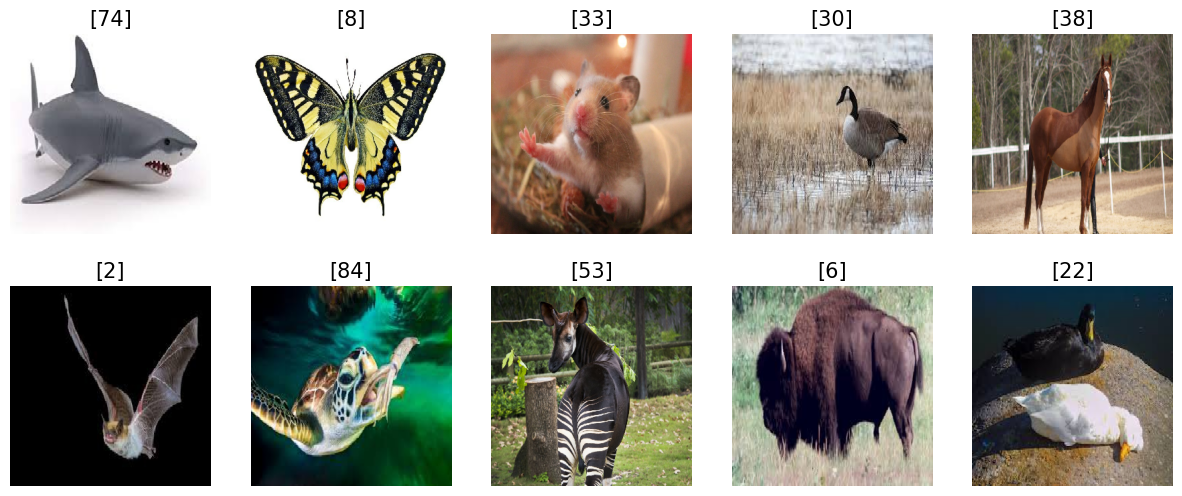

In [23]:
path = 'data/animals'

original_datagen = ImageDataGenerator(rescale=1./ 255,)
original_generator = original_datagen.flow_from_directory(path,
                                                          batch_size=128,
                                                          target_size=(300, 300),
                                                          class_mode='categorical'
                                                          )

for x, y in original_generator:
  print(x.shape, y.shape)
  print(y[0])

  fig, axes = plt.subplots(2, 5)
  fig.set_size_inches(15, 6)
  for i in range(10):
    axes[i//5, i%5].imshow(x[i])
    axes[i//5, i%5].set_title(str(np.where(y[i] == 1)[0]), fontsize=15)
    axes[i//5, i%5].axis('off')
  break

plt.show()

In [27]:
# Data Augmentation
TRAINING_DIR = "data/animals/"
training_datagen = ImageDataGenerator(
    rescale=1./ 255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)


In [28]:
training_generator = training_datagen.flow_from_directory(TRAINING_DIR,
                                                          batch_size=128,
                                                          target_size=(150, 150),
                                                          class_mode='categorical',
                                                          subset='training',
                                                          )
validation_generator = training_datagen.flow_from_directory(TRAINING_DIR,
                                                          batch_size=128,
                                                          target_size=(150, 150),
                                                          class_mode='categorical',
                                                          subset='validation',
                                                          )

Found 4320 images belonging to 90 classes.
Found 1080 images belonging to 90 classes.


### 3. 모델 정의(modeling)

In [29]:
# Conv2D, MaxPooling2D 조합으로 층을 쌓습니다. 첫번째 입력층의 input_shape은 (150, 150, 3)으로 지정합니다.
model = Sequential([
Conv2D(64, (3, 3), activation='relu', input_shape=(150, 150, 3)),
MaxPooling2D(2, 2),
Conv2D(64, (3, 3), activation='relu'),
MaxPooling2D(2, 2),
Conv2D(128, (3, 3), activation='relu'),
MaxPooling2D(2, 2),
Conv2D(128, (3, 3), activation='relu'),
MaxPooling2D(2, 2),
Flatten(),
Dropout(0.5),
Dense(512, activation='relu'),
Dense(90, activation='softmax'),
])

### 4. 모델 생성(compile)

In [30]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
#model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [31]:
# ModelCheckPoint
checkpoint_path = "my_checkpoint.ckpt"
checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                             save_weights_only=True, # weights 정보만
                             save_best_only=True,  # 가장 좋은 모델 정보만
                             monitor='val_loss',
                             verbose=0) # 1: 학습과정 노출, 0: 학습과정 비노출


### 5. 학습(fit)

In [32]:
# 5. 학습(fit)
history = model.fit(training_generator,
                    validation_data=(validation_generator),
                    epochs=20,
                    callbacks=[checkpoint], # 콜백 함수를 통해 checkpoint 생성
                    )

Epoch 1/20
34/34 [==============================] - 83s 2s/step - loss: 4.4413 - acc: 0.0144 - val_loss: 4.3580 - val_acc: 0.0287
Epoch 2/20
34/34 [==============================] - 73s 2s/step - loss: 4.2721 - acc: 0.0352 - val_loss: 4.2197 - val_acc: 0.0463
Epoch 3/20
34/34 [==============================] - 63s 2s/step - loss: 4.1276 - acc: 0.0523 - val_loss: 4.1374 - val_acc: 0.0491
Epoch 4/20
34/34 [==============================] - 65s 2s/step - loss: 3.9929 - acc: 0.0808 - val_loss: 3.9946 - val_acc: 0.0824
Epoch 5/20
34/34 [==============================] - 64s 2s/step - loss: 3.8383 - acc: 0.0975 - val_loss: 3.8733 - val_acc: 0.0926
Epoch 6/20
34/34 [==============================] - 64s 2s/step - loss: 3.7080 - acc: 0.1206 - val_loss: 3.8460 - val_acc: 0.1139
Epoch 7/20
34/34 [==============================] - 64s 2s/step - loss: 3.6048 - acc: 0.1354 - val_loss: 3.6950 - val_acc: 0.1185
Epoch 8/20
34/34 [==============================] - 75s 2s/step - loss: 3.4376 - acc: 0.16

In [33]:
model.load_weights(checkpoint_path)

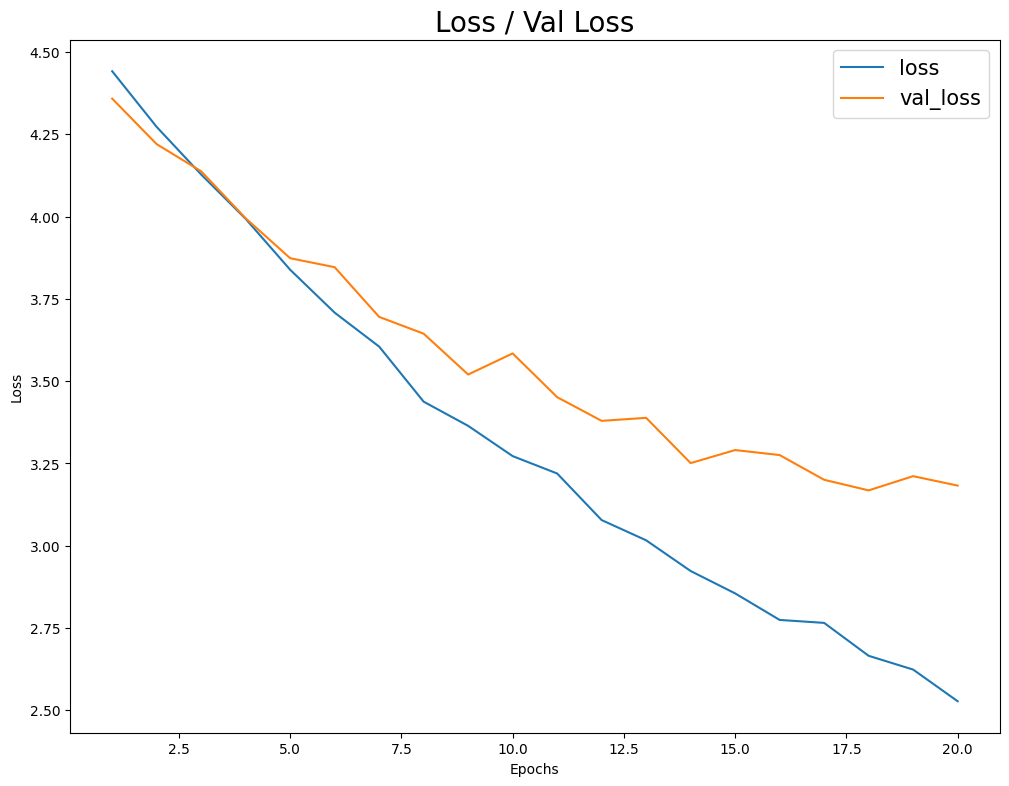

In [35]:
# Loss 시각화
plt.figure(figsize=(12, 9))
plt.plot(np.arange(1, 21), history.history['loss'])
plt.plot(np.arange(1, 21), history.history['val_loss'])
plt.title('Loss / Val Loss', fontsize=20)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['loss', 'val_loss'], fontsize=15)
plt.show()

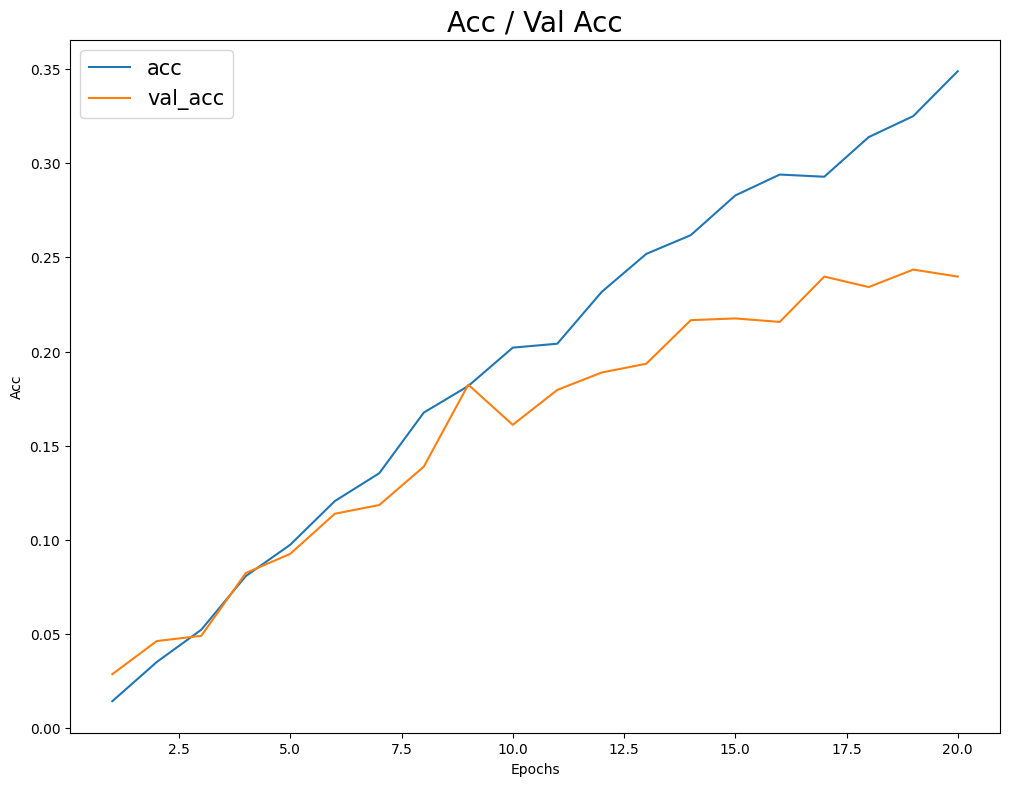

In [37]:
# Accuracy 시각화
plt.figure(figsize=(12, 9))
plt.plot(np.arange(1, 21), history.history['acc'])
plt.plot(np.arange(1, 21), history.history['val_acc'])
plt.title('Acc / Val Acc', fontsize=20)
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend(['acc', 'val_acc'], fontsize=15)
plt.show()

In [ ]:
# Load the pre-trained VGG16 model
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze the convolutional layers
for layer in vgg_base.layers:
    layer.trainable = False

# Create a new model and add VGG16 as the base
model = Sequential([
    vgg_base,
    Flatten(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dense(90, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 5. 학습(fit)
history = model.fit(training_generator,
                      validation_data=(validation_generator),
                      epochs=3,
                      callbacks=[checkpoint], # 콜백 함수를 통해 checkpoint 생성
                    )

Epoch 1/3
34/34 [==============================] - ETA: 0s - loss: 4.4146 - accuracy: 0.0472
Epoch 1: val_loss did not improve from 2.70321
34/34 [==============================] - 70s 2s/step - loss: 4.4146 - accuracy: 0.0472 - val_loss: 3.9281 - val_accuracy: 0.1167
Epoch 2/3
34/34 [==============================] - ETA: 0s - loss: 3.6160 - accuracy: 0.1609
Epoch 2: val_loss did not improve from 2.70321
34/34 [==============================] - 63s 2s/step - loss: 3.6160 - accuracy: 0.1609 - val_loss: 3.3509 - val_accuracy: 0.2250
Epoch 3/3
34/34 [==============================] - ETA: 0s - loss: 3.0594 - accuracy: 0.2551
Epoch 3: val_loss did not improve from 2.70321
34/34 [==============================] - 66s 2s/step - loss: 3.0594 - accuracy: 0.2551 - val_loss: 3.0483 - val_accuracy: 0.2880


### 03. Train VGG16